In [2]:
import csv
import pandas as pd
import numpy as np
import gzip
from patsy import dmatrix
import shutil
import matplotlib.colors as mcolors
from sklearn.feature_selection import f_classif
import dataframe_image as dfi
import dask.dataframe as dd
from matplotlib.colors import TwoSlopeNorm
from sklearn.linear_model import LogisticRegression
import pyarrow.csv as pv
from matplotlib.colors import LogNorm
from sklearn import tree
import xgboost as xgb
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.linear_model import LinearRegression
import pyarrow.parquet as pq
from sklearn.tree import export_graphviz
import graphviz
from scipy.optimize import curve_fit
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from lifelines.utils import k_fold_cross_validation
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.tree import plot_tree
from sklearn.datasets import make_regression
import seaborn as sns
import dask.dataframe as dd
import matplotlib.cm as cm
from sklearn.preprocessing import StandardScaler
import time
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot
from numpy.polynomial.polynomial import Polynomial
import sys
import shap
from lifelines import CoxPHFitter
from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import RandomForestClassifier  
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
import lifelines
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.interpolate import UnivariateSpline
from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter
from lifelines.utils import concordance_index
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingClassifier
from sksurv.tree import SurvivalTree
from sksurv.util import Surv
from sklearn.model_selection import GridSearchCV
from sksurv.ensemble import RandomSurvivalForest
from sklearn.metrics import log_loss
from scipy.stats import entropy
import pickle
#from lifelines.utils import add_spline
import statsmodels.api as sm
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from lifelines.statistics import multivariate_logrank_test
from lifelines.statistics import logrank_test
from statsmodels.nonparametric.smoothers_lowess import lowess
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn_pandas import DataFrameMapper
from sksurv.metrics import concordance_index_censored
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import brier_score
from sklearn.preprocessing import OrdinalEncoder
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis, GradientBoostingSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder
from matplotlib.ticker import FuncFormatter
from lifelines.statistics import logrank_test

C:\ProgramData\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
df_bin = pd.read_csv('thesis__data_res.csv', usecols = ['MORTSTAT', 'YEAR', 'EDUCREC1', 'MORTDODY'])

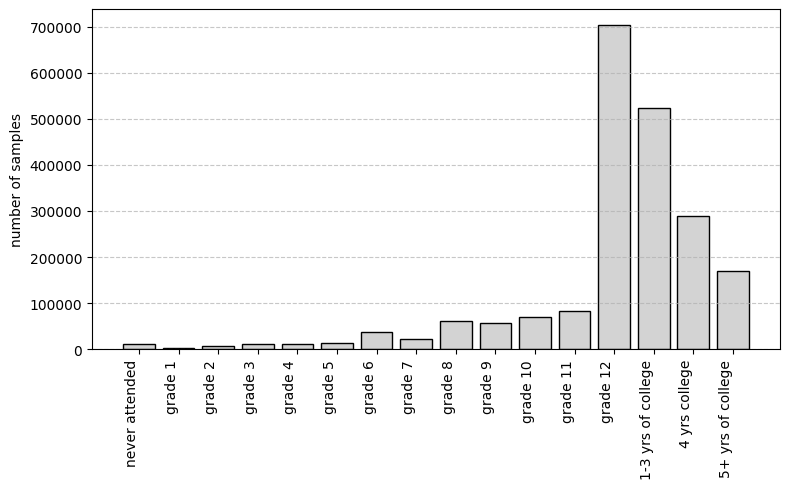

In [4]:
# select only sample avalibale for moratlity tracking
df_bin = df_bin[(df_bin['MORTSTAT']==1) | (df_bin['MORTSTAT']==2)]

# selecet only samples with inforormation for EDUCREC1
df_bin = df_bin[(df_bin['EDUCREC1']>=1) & (df_bin['EDUCREC1']<=16)]

# count the number of samples in each EDUCREC1 category
educrec1_counts = df_bin['EDUCREC1'].value_counts().sort_index()

# define labels for names of categories of EDUCREC1
educrec1_labels = {
    1: 'never attended',
    2: 'grade 1',
    3: 'grade 2',
    4: 'grade 3',
    5: 'grade 4',
    6: 'grade 5',
    7: 'grade 6',
    8: 'grade 7',
    9: 'grade 8',
    10: 'grade 9',
    11: 'grade 10',
    12: 'grade 11',
    13: 'grade 12',
    14: '1-3 yrs of college',
    15: '4 yrs college',
    16: '5+ yrs of college'
}

# apply the labels to the x-axis ticks
labels = [educrec1_labels.get(x, str(x)) for x in educrec1_counts.index]

# plot bar graph
plt.figure(figsize=(8, 5))
plt.bar(educrec1_counts.index, educrec1_counts.values, color='lightgrey', edgecolor='black')
plt.xticks(educrec1_counts.index, labels, rotation=90, ha='right')  
plt.ylabel('number of samples')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [5]:
# create the TIMETOEVENT column
df_bin['TIMETOEVENT'] = df_bin.apply(
    lambda row: row['MORTDODY'] - row['YEAR'] if row['MORTSTAT'] == 1 else 9999, 
    axis=1)

In [6]:
# log-rank splitting desission 1

# get candidate cut points
educrec1_sorted = sorted(df_bin['EDUCREC1'].unique())

best_cut_point = None
max_abs_log_rank_stat = 0

for i in range(1, len(educrec1_sorted)):
    # split at current cut point
    group1 = df_bin[df_bin['EDUCREC1'] <= educrec1_sorted[i]]
    group2 = df_bin[df_bin['EDUCREC1'] > educrec1_sorted[i]]

    # perform log-rank test
    results = logrank_test(group1['TIMETOEVENT'], group2['TIMETOEVENT'], event_observed_A=group1['MORTSTAT'], event_observed_B=group2['MORTSTAT'])
    # get value of log-rank statistics
    l_r_stat =  results.test_statistic 
    
    # compare values of l_r_stats
    if l_r_stat > max_abs_log_rank_stat:
        best_cut_point = educrec1_sorted[i]
        max_abs_log_rank_stat = l_r_stat

# print best cut point
print(best_cut_point)

11


In [7]:
# log-rank splitting decision 2 (applied on right bin)

# restrict dataset
df_bin2 = df_bin[df_bin['EDUCREC1']>11]
 
# get candidate cut points
educrec1_sorted2 = sorted(df_bin2['EDUCREC1'].unique())

best_cut_point2 = None
max_abs_log_rank_stat2 = 0

for i in range(1, len(educrec1_sorted2)):
    # split at current cut point
    group1 = df_bin2[df_bin2['EDUCREC1'] <= educrec1_sorted2[i]]
    group2 = df_bin2[df_bin2['EDUCREC1'] > educrec1_sorted2[i]]
    
    # perform log-rank test
    results = logrank_test(group1['TIMETOEVENT'], group2['TIMETOEVENT'], event_observed_A=group1['MORTSTAT'], event_observed_B=group2['MORTSTAT'])
    # get value of log-rank statistics
    l_r_stat =  results.test_statistic 
    
    # compare values of l_r_stats
    if l_r_stat > max_abs_log_rank_stat2:
        best_cut_point2 = educrec1_sorted2[i]
        max_abs_log_rank_stat2 = l_r_stat

# Output the best cut point
print(best_cut_point2)

13


In [8]:
# log-rank splitting 3

# restric dataset
df_bin3 = df_bin[df_bin['EDUCREC1']<=11]

# get candidate cut points
educrec1_sorted3 = sorted(df_bin3['EDUCREC1'].unique())

best_cut_point6 = None
max_abs_log_rank_stat3 = 0

for i in range(1, len(educrec1_sorted3)):
    # split at current cut point
    group1 = df_bin3[df_bin3['EDUCREC1'] <= educrec1_sorted3[i]]
    group2 = df_bin3[df_bin3['EDUCREC1'] > educrec1_sorted3[i]]

    # perform log-rank test
    results = logrank_test(group1['TIMETOEVENT'], group2['TIMETOEVENT'], event_observed_A=group1['MORTSTAT'], event_observed_B=group2['MORTSTAT'])
    # get value of log-rank statistics
    l_r_stat =  results.test_statistic 
    
    # compare values of l_r_stats
    if l_r_stat > max_abs_log_rank_stat3:
        best_cut_point3 = educrec1_sorted3[i]
        max_abs_log_rank_stat3 = l_r_stat

# Output the best cut point
print(best_cut_point3)

9


In [9]:
# visualize binning

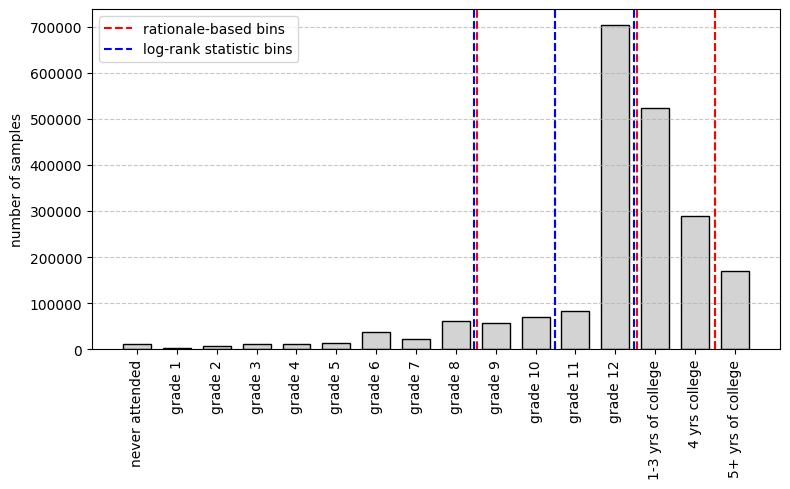

In [10]:
# Apply the labels to the x-axis ticks
labels = [educrec1_labels.get(x, str(x)) for x in educrec1_counts.index]

# cuts ratioanle and knowledge-based binning
cuts_knowl = [9.5, 13.5, 15.5]
# cuts log-rank statistics binning
cuts_logrank = [9.5, 11.5, 13.5]

# plot the bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(educrec1_counts.index, educrec1_counts.values, color='lightgrey', edgecolor='black', width =-0.7)

# add vertical lines for each cut point (rationale based binnning)
for cut in cuts_knowl:
    if cut != 15.5:
        plt.axvline(x=cut + 0.035 , color='red', linestyle='--')
    else:
        plt.axvline(x=cut, color='red', linestyle='--')
    
# add vertical lines for each cut point (log-rank statistics based binnning)
for cut in cuts_logrank:
    if cut != 11.5:
        plt.axvline(x=cut - 0.035, color='blue', linestyle='--')
    else:
        plt.axvline(x=cut, color='blue', linestyle='--')

# add labels, grid, and title
plt.xticks(educrec1_counts.index, labels, rotation=90, ha='center')
plt.ylabel('number of samples')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# add the legend with single entries for each type of cut
plt.axvline(x=cuts_knowl[2], color='red', linestyle='--', label='rationale-based bins')
plt.axvline(x=cuts_logrank[1], color='blue', linestyle='--', label='log-rank statistic bins')

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [11]:
# right edge of the bin included left not
bins_knowl = [0, 9, 13, 15, 16]
labels_knowl = ['primary\nschool', 'high\nschool', 'college', 'PhD']
bins_logrank = [0, 9, 11, 13, 16]
labels_logrank = ['bin 1', 'bin 2', 'bin 3', 'bin 4']

# add a new column with the binned values
df_bin['EDUCREC1_binned_knowl'] = pd.cut(df_bin['EDUCREC1'], bins=bins_knowl, right=True, labels=labels_knowl)
df_bin['EDUCREC1_binned_logrank'] = pd.cut(df_bin['EDUCREC1'], bins=bins_logrank, right=True, labels=labels_logrank)

# Count the number of samples in each binned category
educrec1_binned_counts_knowl = df_bin['EDUCREC1_binned_knowl'].value_counts().sort_index()
educrec1_binned_counts_logrank = df_bin['EDUCREC1_binned_logrank'].value_counts().sort_index()

# reindex counts to ensure both series have the same index for alignment
educrec1_binned_counts_knowl = educrec1_binned_counts_knowl.reindex(labels_knowl, fill_value=0)
educrec1_binned_counts_logrank = educrec1_binned_counts_logrank.reindex(labels_logrank, fill_value=0)

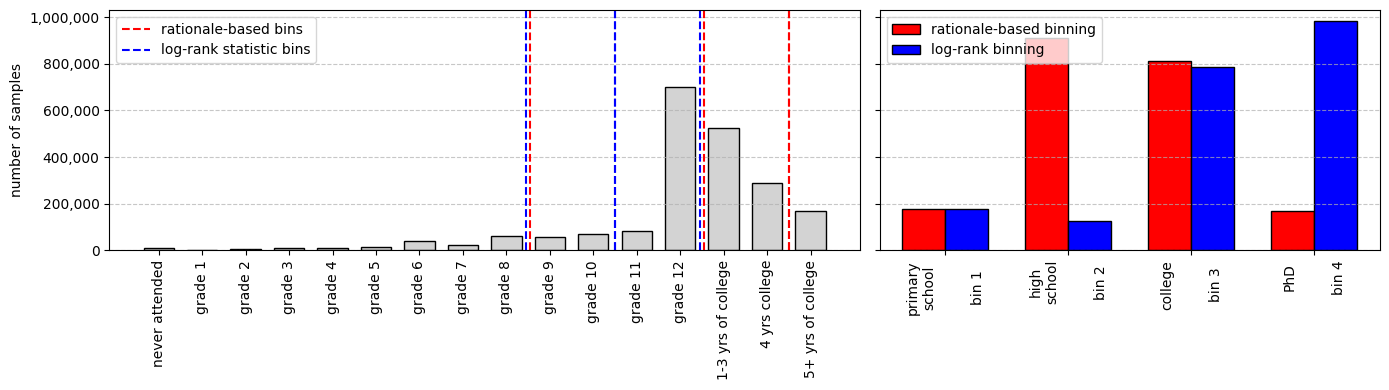

In [12]:
# set positions for the pairs of bars
x_pos = np.arange(len(educrec1_binned_counts_knowl))

# create the figure with two subplots (left and right)
fig, axs = plt.subplots(1, 2, figsize=(14, 4), sharey=True, gridspec_kw={'width_ratios': [3, 2]})

# left plot (counts with cuts)
axs[0].bar(educrec1_counts.index, educrec1_counts.values, color='lightgrey', edgecolor='black', width=-0.7)

# add vertical lines for each cut point (knowledge-based and log-rank)
for cut in cuts_knowl:
    if cut != 15.5:
        axs[0].axvline(x=cut+0.04, color='red', linestyle='--')
    else:
        axs[0].axvline(x=cut, color='red', linestyle='--')
for cut in cuts_logrank:
    if cut != 11.5:
        axs[0].axvline(x=cut-0.04, color='blue', linestyle='--')
    else:
        axs[0].axvline(x=cut, color='blue', linestyle='--')

# add labels, title, and grid to the left plot
axs[0].set_xticks(educrec1_counts.index)
axs[0].set_xticklabels(labels, rotation=90, ha='center')
axs[0].set_ylabel('number of samples')
axs[0].grid(axis='y', linestyle='--', alpha=0.7)

# add legend to the left plot
axs[0].axvline(x=cuts_knowl[2], color='red', linestyle='--', label='rationale-based bins')
axs[0].axvline(x=cuts_logrank[1], color='blue', linestyle='--', label='log-rank statistic bins')
axs[0].legend(loc='upper left')

# right plot (knowledge-based vs log-rank binning)
bar_width = 0.35
axs[1].bar(x_pos - bar_width / 2, educrec1_binned_counts_knowl.values, width=bar_width, color='red', edgecolor='black', label='rationale-based binning')
axs[1].bar(x_pos + bar_width / 2, educrec1_binned_counts_logrank.values, width=bar_width, color='blue', edgecolor='black', label='log-rank binning')

# combine both labels lists with extra space between them
combined_labels = [f"{l1}\n\n\n{l2}" for l1, l2 in zip(labels_knowl, labels_logrank)]  
axs[1].set_xticks(x_pos)
axs[1].set_xticklabels(combined_labels, rotation=90)
axs[1].grid(axis='y', linestyle='--', alpha=0.7)
axs[1].legend()

formatter = FuncFormatter(lambda x, _: f'{int(x):,}')
axs[1].yaxis.set_major_formatter(formatter)
axs[0].yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.savefig('binning.png', format='png')
plt.show()